This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# RADOLAN Radar Network

In this chapter the RW-product is shown in WGS84 and the RADOLAN [Polar Stereographic Projection](radolan_grid.ipynb#Polar-Stereographic-Projection). All for the compositing process used radars are extracted from the metadata and plotted with their respective maximum range rings and location information.

In [1]:
import datetime
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
from IPython import get_ipython
from wetterdienst.provider.dwd.radar import DwdRadarParameter, DwdRadarValues
from wetterdienst.provider.dwd.radar.api import DwdRadarSites

warnings.filterwarnings("ignore")
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
from osgeo import osr

# load radolan data
start_date = datetime.datetime.utcnow()

radar_data = DwdRadarValues(
    parameter=DwdRadarParameter.RADOLAN_CDC.RW_REFLECTIVITY,
    start_date=start_date - datetime.timedelta(hours=2),
    end_date=start_date,
)

results = radar_data.query()
rwdata, rwattrs = wrl.io.read_radolan_composite(next(results).data)

/home/runner/micromamba-root/envs/wradlib-notebooks/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:02<08:35,  2.16s/it]

In [2]:
# print the available attributes
print("RW Attributes:", rwattrs)

RW Attributes: {'producttype': 'RW', 'datetime': datetime.datetime(2022, 11, 14, 6, 50), 'radarid': '10000', 'datasize': 1620000, 'formatversion': 3, 'maxrange': '150 km', 'radolanversion': '2.29.1', 'precision': 0.1, 'intervalseconds': 3600, 'nrow': 900, 'ncol': 900, 'radarlocations': ['asb', 'boo', 'ros', 'hnr', 'umd', 'pro', 'ess', 'fld', 'drs', 'neu', 'nhb', 'oft', 'eis', 'tur', 'isn', 'fbg', 'mem'], 'moduleflag': 1, 'nodataflag': -9999, 'secondary': array([   188,    189,    190, ..., 748746, 748747, 749641]), 'nodatamask': array([     0,      1,      2, ..., 809997, 809998, 809999]), 'cluttermask': array([], dtype=int64)}


In [3]:
# mask data
sec = rwattrs["secondary"]
rwdata.flat[sec] = -9999
rwdata = np.ma.masked_equal(rwdata, -9999)

# create radolan projection object
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# create wgs84 projection object
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

# get radolan grid
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900)
x1 = radolan_grid_xy[:, :, 0]
y1 = radolan_grid_xy[:, :, 1]

# convert to lonlat
radolan_grid_ll = wrl.georef.reproject(
    radolan_grid_xy, projection_source=proj_stereo, projection_target=proj_wgs
)
lon1 = radolan_grid_ll[:, :, 0]
lat1 = radolan_grid_ll[:, :, 1]

In [4]:
# range array 150 km
print("Max Range: ", rwattrs["maxrange"])
r = np.arange(1, 151) * 1000
# azimuth array 1 degree spacing
az = np.linspace(0, 360, 361)[0:-1]

Max Range:  150 km


In [5]:
# get radar dict
radars = DwdRadarSites()

In [6]:
def plot_radar(radar, ax, proj):

    site = (radar["longitude"], radar["latitude"], radar["heightantenna"])

    # build polygons for maxrange rangering
    polygons = wrl.georef.spherical_to_polyvert(r, az, 0, site, proj=proj)
    polygons = polygons[..., 0:2]
    polygons.shape = (len(az), len(r), 5, 2)
    polygons = polygons[:, -1, :, :]

    x_loc, y_loc = wrl.georef.reproject(
        site[0], site[1], projection_source=proj_wgs, projection_target=proj
    )

    # create PolyCollections and add to respective axes
    polycoll = mpl.collections.PolyCollection(
        polygons, closed=True, edgecolors="r", facecolors="r"
    )
    ax.add_collection(polycoll, autolim=True)

    # plot radar location and information text
    ax.plot(x_loc, y_loc, "r+")
    ax.text(x_loc, y_loc, radar["location"], color="r")

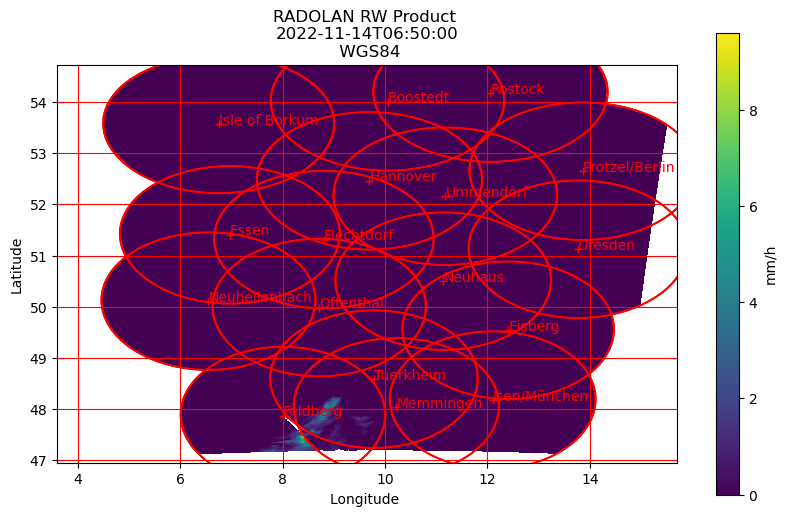

In [7]:
# plot two projections side by side
fig1 = pl.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(111, aspect="equal")
pm = ax1.pcolormesh(lon1, lat1, rwdata, cmap="viridis")
cb = fig1.colorbar(pm, shrink=0.75)
cb.set_label("mm/h")
pl.xlabel("Longitude ")
pl.ylabel("Latitude")
pl.title("RADOLAN RW Product \n" + rwattrs["datetime"].isoformat() + "\n WGS84")
pl.xlim((lon1[0, 0], lon1[-1, -1]))
pl.ylim((lat1[0, 0], lat1[-1, -1]))
pl.grid(color="r")
for radar_id in rwattrs["radarlocations"]:
    # get radar coords etc from dict
    radar = radars.by_odimcode(radar_id)
    plot_radar(radar, ax1, proj_wgs)

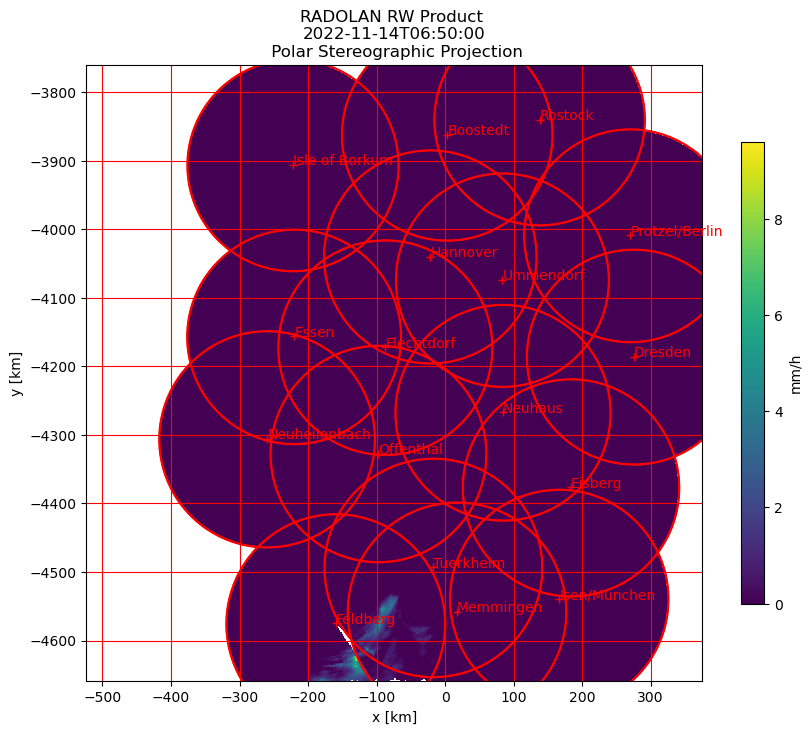

In [8]:
fig2 = pl.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, aspect="equal")
pm = ax2.pcolormesh(x1, y1, rwdata, cmap="viridis")
cb = fig2.colorbar(pm, shrink=0.75)
cb.set_label("mm/h")
pl.xlabel("x [km]")
pl.ylabel("y [km]")
pl.title(
    "RADOLAN RW Product \n"
    + rwattrs["datetime"].isoformat()
    + "\n Polar Stereographic Projection"
)
pl.xlim((x1[0, 0], x1[-1, -1]))
pl.ylim((y1[0, 0], y1[-1, -1]))
pl.grid(color="r")
for radar_id in rwattrs["radarlocations"]:
    # get radar coords etc from dict
    radar = radars.by_odimcode(radar_id)
    plot_radar(radar, ax2, proj_stereo)